In [ ]:
try:
    from google.colab import drive
    #%pip install -U opencv-python
    #%pip install -U opencv-contrib-python
    drive.mount('/content/drive')
    workspace = '/content/drive/MyDrive'
except:
    workspace = '.'

import os
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models as models

from collections import OrderedDict

root = os.path.join(workspace, 'Tutorial-7')
label_path = os.path.join(root, 'label.csv')

Mounted at /content/drive


# **Deep Image Retrieval**

Although we have introduced the deep learning in the scenario of classification, it can be used for image retrieval. The idea is to use the deep convolutional networks (DCNN) trained for classification as a feature extractor. By feeding images into the networks, We can flatten the feature maps of the convolutional layers as feature vectors.

# **1. Off-the-shell methods**

This can be done by using off-the-shell methods which employ the pretrained DCNN (e.g., ResNet, VGG) directly and keep the paramaters unchanged. Let's take VGG-16 as an example. It can be loaded as follows.

ID filename label split
-- -------- ----- -----
0   1.jpg     1   train
1   2.jpg     0    val 
2   3.jpg     1   train
3   4.jpg     1    val 
4   5.jpg     0    val 
5   6.jpg     0   train
6   7.jpg     0   train
7   8.jpg     0    val 
8   9.jpg     1   train
9   10.jpg    1    val 
10  11.jpg    0   train
11  12.jpg    1   train
12  13.jpg    1    val 
13  14.jpg    0   train


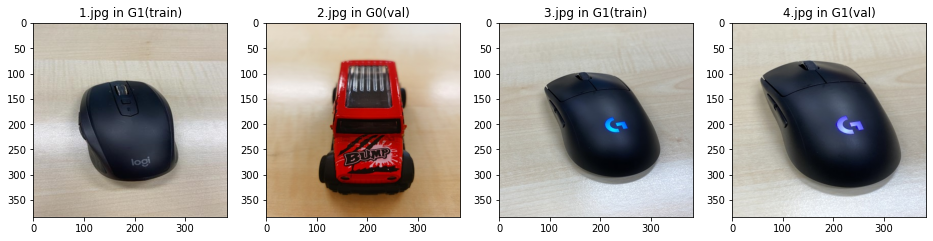

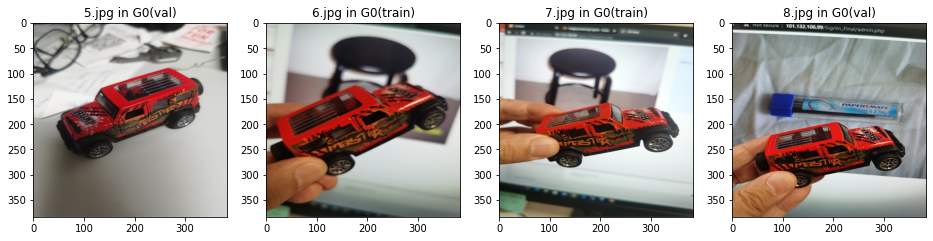

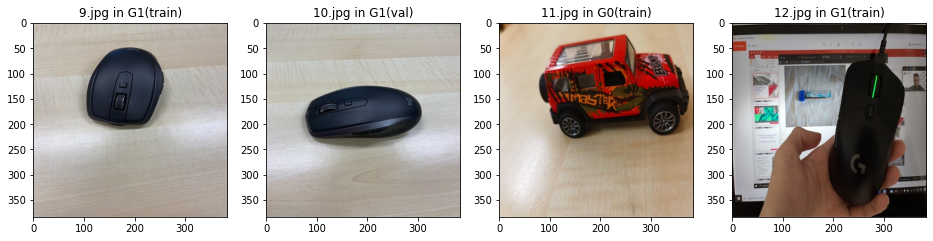

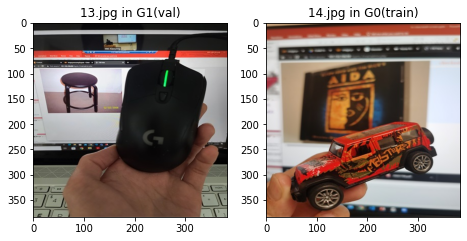

In [ ]:
# load dataset
def labels2strs(labels: list) -> list:
    lengths = np.max([[len(j) for j in i] for i in labels], axis=0)
    format_str = ' '.join(['{:^%ds}'%length for length in lengths])
    seps = ' '.join(['-'*length for length in lengths])
    contents = [format_str.format(*row) for row in labels]
    contents.insert(1, seps)
    return contents

if os.path.exists(label_path):
    with open(label_path) as f:
        flabels = list(csv.reader(f))
    print(*labels2strs(flabels), sep='\n')
else:
    raise ValueError('Invalid label file path [%s]'%label_path)


samples = {'train': [], 'val': [], 'all': []}

class Sample:
    def __init__(self, idx=0, fname='', img=None, feat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.feat = feat
        self.label = label
        self.pred = None

for idx, fname, label, split in flabels[1:]:
    idx, label = int(idx), int(label)
    if idx % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, idx%4+1)
    plt.title(f'{fname} in G{label}({split})')

    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        raise ValueError('%s not found' % fpath)
    else:
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
        if idx == 0:
          H, W, C = img.shape
        else:
          img = cv2.resize(img, (W, H))
        
        plt.imshow(img)
        
        samples[split].append(Sample(idx, fname, img, None, label))
        samples['all'].append(samples[split][-1])


In [ ]:
# load a pretrained DCNN (e.g., VGG)
class VGGFeature(nn.Module):
    def __init__(self, pretrained=True, layer=28):
        super().__init__()
        self.net = models.vgg16(pretrained).features.eval()
        self.layer = layer
        self.requires_grad_(False)

    def forward(self, x):
        for idx, layer in enumerate(self.net):
            x = layer(x)
            if idx == self.layer:
                return x

force_cpu = False

if torch.cuda.is_available() and not force_cpu:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('We are using device', device)

VGG = VGGFeature().to(device)

We are using device cpu


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Then we can feed images into the networks and take the feature maps out. To make things easier, we use the one from the last convolutional layer (the one in front of the fully connected layers).

In [ ]:
# extract the feature vectors using pretrained DCNN
for sample in samples['all']:
    img = np.ascontiguousarray(sample.img.transpose(2, 0, 1)) # HWC -> CHW
    img = torch.tensor(img, dtype=torch.float32, device=device)[None] # np.array -> torch.tensor & CHW -> NCHW
    sample.feat = VGG(img)

With feature vectors extracted, the retrieval process is the same as what we have done using conventional methods. Let's use cosine smilarity as the metric for preparing the ranked list.

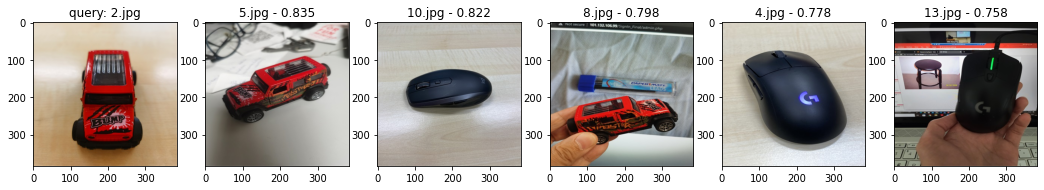

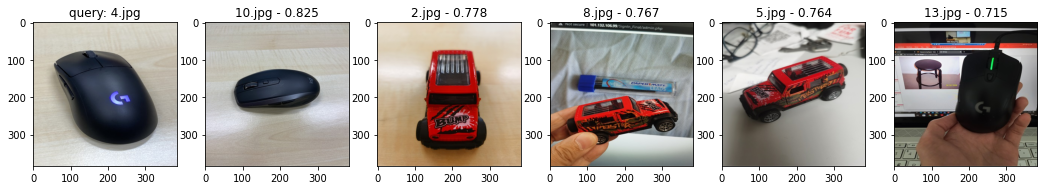

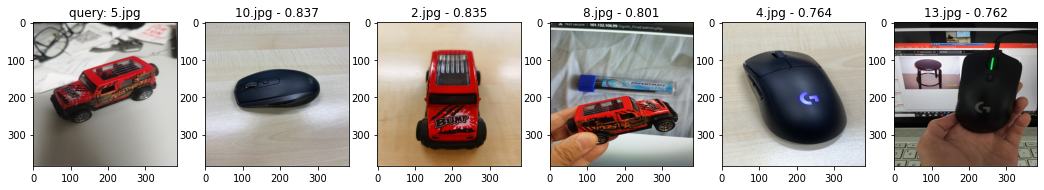

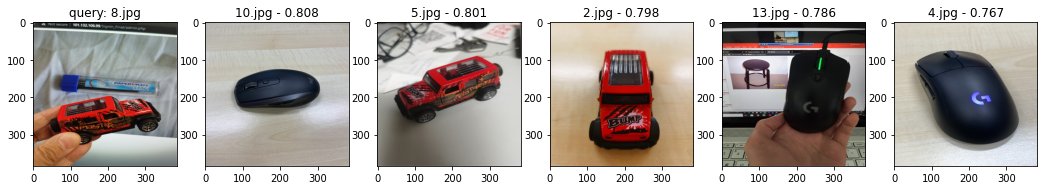

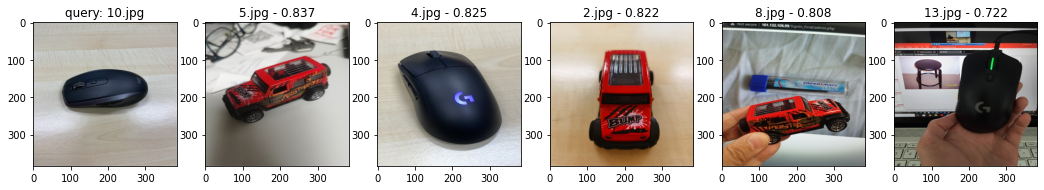

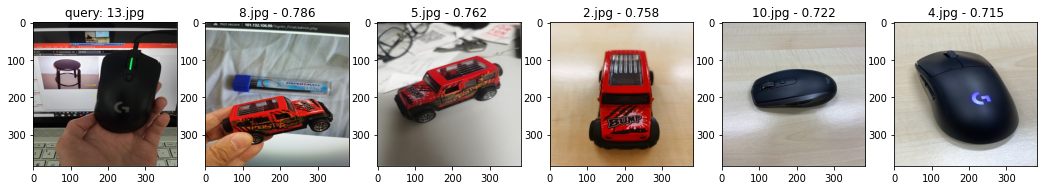

In [ ]:
# prepare and display the ranked list by showing in each row the query and the most relevant images (with similarities indicated)
cos = nn.CosineSimilarity(dim=1)

all_feats = torch.cat([sample.feat.view(1, -1) for sample in samples['val']], dim=0)
for idx, sample in enumerate(samples['val']):
    dists = cos(sample.feat.view(1, -1).expand_as(all_feats), all_feats)
    simlarity, orders = torch.sort(dists, descending=True)
    
    plt.figure(figsize=(18,4))
    plt.subplot(1, 6, 1)
    plt.title(f'query: {sample.fname}')
    plt.imshow(sample.img)
    
    for i, order in enumerate(orders[1:6]):
        plt.subplot(1, 6, i+2)
        result = samples['val'][order]
        plt.title(f'{result.fname} - %.3f' % simlarity[i+1])
        plt.imshow(result.img)

It works well. We can project the vectors into the a 2D space using t-NSE for a more intuitive view.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


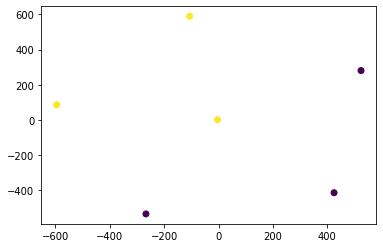

In [ ]:
all_feats = [np.array(sample.feat.cpu().view(1, -1)[0]) for sample in samples['val']]
labels = [sample.label for sample in samples['val']]

tsne = TSNE()
X_embedded = tsne.fit_transform(all_feats)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)

Instead of employing the feature maps directly, it's popular to "summarize" them for a more compact (or meaningful) feature vectors before use. Let's use maxpooling this time.

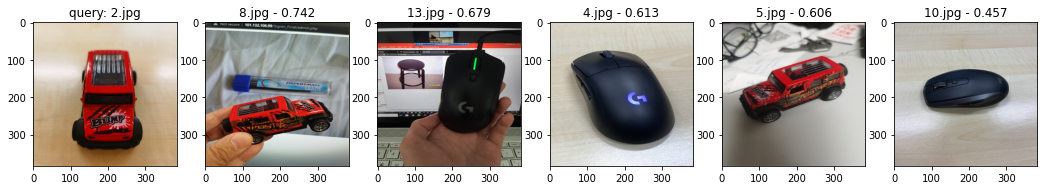

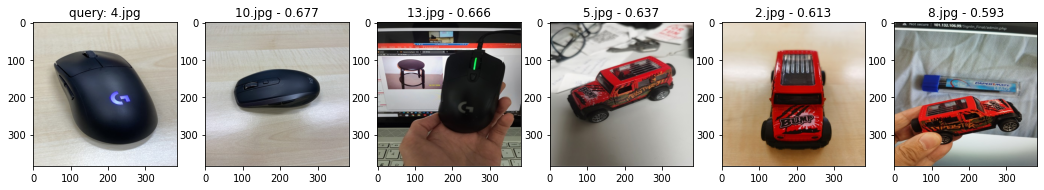

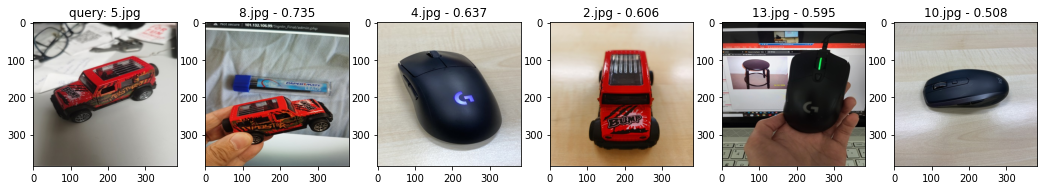

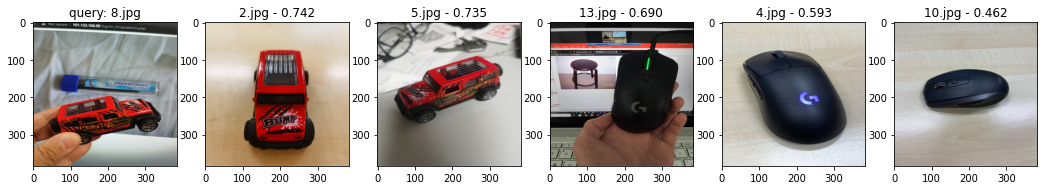

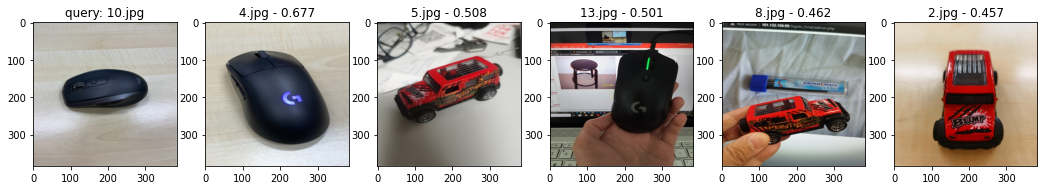

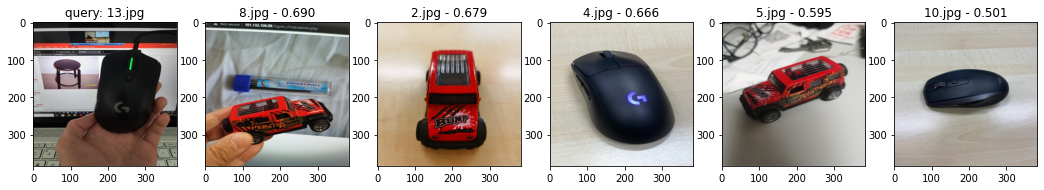

In [ ]:
# use maxpooling to prepare the feature vectors
# redo the retrieval and display the results
for idx, sample in enumerate(samples['all']):
    sample.feat_vec = sample.feat.max(dim=3)[0].max(dim=2)[0]
    # sample.feat_vec = sample.feat.mean(dim=(2,3))

all_feats = torch.cat([sample.feat_vec.view(1, -1) for sample in samples['val']], dim=0)
for idx, sample in enumerate(samples['val']):
    dists = cos(sample.feat_vec.view(1, -1).expand_as(all_feats), all_feats)
    simlarity, orders = torch.sort(dists, descending=True)
    
    plt.figure(figsize=(18,4))
    plt.subplot(1, 6, 1)
    plt.title(f'query: {sample.fname}')
    plt.imshow(sample.img)
    
    for i, order in enumerate(orders[1:6]):
        plt.subplot(1, 6, i+2)
        result = samples['val'][order]
        plt.title(f'{result.fname} - %.3f'%simlarity[i+1])
        plt.imshow(result.img)

It works even better than using the early version, and the demensionality has been reduced by 99.9% (from 512\*32\*32 to 512). We can check the distribution with t-NSE again.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


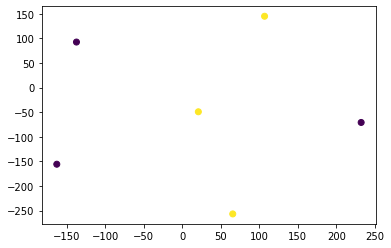

In [ ]:
# check with t-NSE again

all_feats = [np.array(sample.feat_vec.cpu()[0]) for sample in samples['val']]
labels = [sample.label for sample in samples['val']]

tsne = TSNE()
X_embedded = tsne.fit_transform(all_feats)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)



# **2. Fine-tunned Methods**

This can be done by using fine-tunned methods as well, in which we update the parameters (weights) for the DCNN to address the domain shift. Let's take the verification-based Siamese networks as an example.

To this end, we need to build a 2-stream networks with each of them being a DCNN. But we only take the layers from the input to the last convolutional layer. Then we add X fully connected layers as the similarity reasoner of image paris. The images are then fed into the networks as pairs, in which we put the similarity 1 for the relvant pairs and -1 for the irrelevant pairs. The ratinale bebind is that we are using the DCNN to learn a metric that is able to distinguishs (classifies) the relevant from irrelevant pairs.

In [ ]:
# build the networks
class SiameseNet(nn.Module):
    def __init__(self, in_features=512, mid_features=256, out_features=128):
        super().__init__()
        self.net = nn.Sequential(OrderedDict([
            ('Input', nn.Linear(in_features, mid_features)),
            ('Act', nn.Sigmoid()),
            ('Output', nn.Linear(mid_features, out_features)),
        ]))
        self.cos_sim = nn.CosineSimilarity(dim=1)

    def forward(self, x, y):
        feat_x = self.net(x)
        feat_y = self.net(y)
        return self.cos_sim(feat_x, feat_y)

Net = SiameseNet().to(device)
optimizer = optim.Adam(Net.parameters(), lr=1e-3, betas=(0.9, 0.999))
criterion = nn.MSELoss()
num_iters = 100
batch_size = 32
n_train = len(samples['train'])
train_inputs = torch.cat([sample.feat_vec for sample in samples['train']], dim=0).to(device)
train_labels = torch.tensor([sample.label for sample in samples['train']]).to(device)

# print(train_inputs.shape, train_labels.shape)
# training
for it in range(num_iters):
    idx_x = torch.randint(n_train, size=(batch_size,), device=device)
    idx_y = torch.randint(n_train, size=(batch_size,), device=device)
    input_x = train_inputs[idx_x]
    input_y = train_inputs[idx_y]
    target = (train_labels[idx_x] == train_labels[idx_y]).to(torch.float32) * 2 - 1
    output = Net(input_x, input_y)
    # print(output, target)
    loss = criterion(output, target)
    if it % 10 == 0:
        print(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

1.6855369806289673
0.05066909268498421
0.00812680646777153
0.0018642386421561241
0.0010094715980812907
0.000623021915089339
0.0003906779456883669
0.00027924077585339546
0.00025678370730020106
0.0002415712660877034


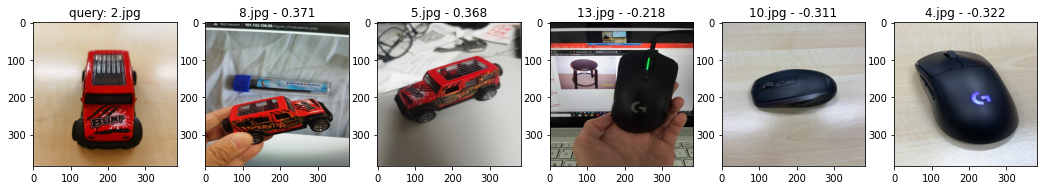

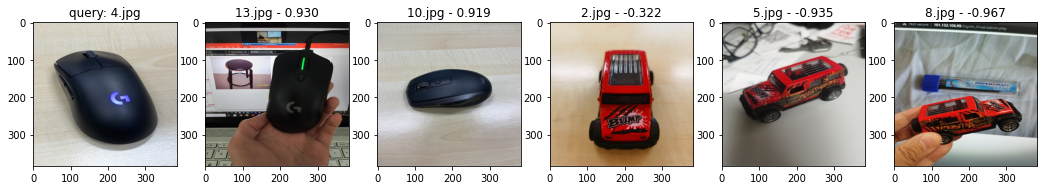

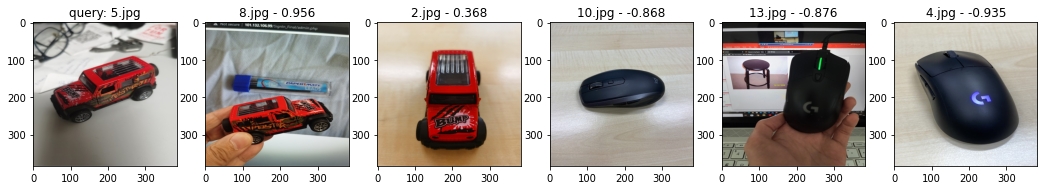

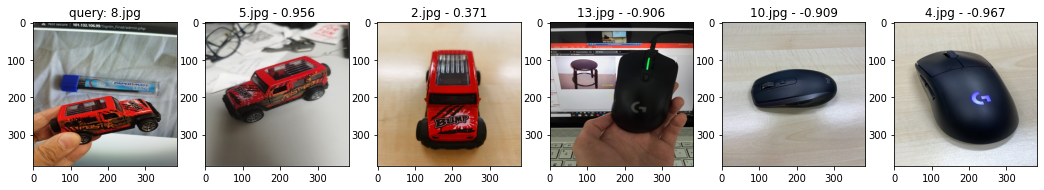

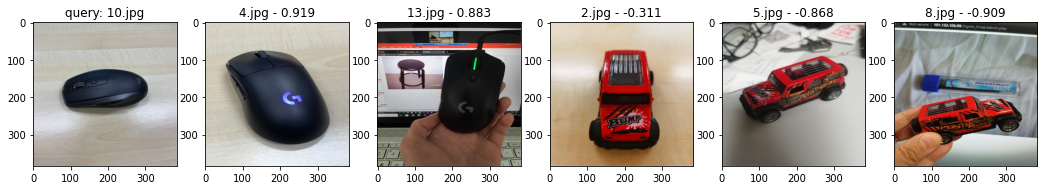

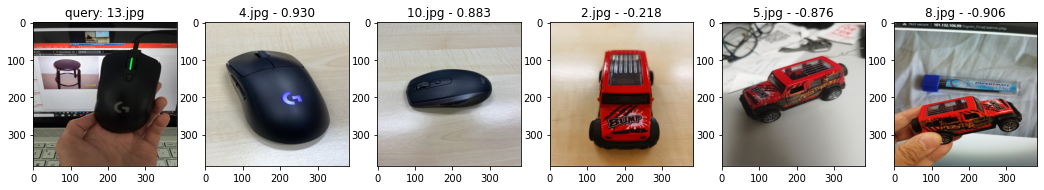

In [ ]:
all_feats = torch.cat([sample.feat_vec.view(1, -1) for sample in samples['val']], dim=0)
Net.eval()

for idx, sample in enumerate(samples['val']):
    dists = Net(sample.feat_vec.view(1, -1).expand_as(all_feats), all_feats)
    simlarity, orders = torch.sort(dists, descending=True)
    
    plt.figure(figsize=(18,4))
    plt.subplot(1, 6, 1)
    plt.title(f'query: {sample.fname}')
    plt.imshow(sample.img)
    
    for i, order in enumerate(orders[1:6]):
        plt.subplot(1, 6, i+2)
        result = samples['val'][order]
        plt.title(f'{result.fname} - %.3f'%simlarity[i+1])
        plt.imshow(result.img)

Well done! The sign of the matching score show the relationship between the query image and the found ones